# Quantum computing for quantum chemistry workshop:

## Estimating H₂ ground state energy using VQE with hardware efficient Ansatz

### 1) Introduction :
For molecules, the Schrödinger equation can be solved **analytically only** in simplified cases, such as the hydrogen molecular ion (H₂⁺). 

The classical **FCI** (full configuration interaction) method, while provides exact solutions to time-independent, non-relativistic Schrödinger equation, is a numerical approach that considers all possible electron configurations within a given basis set, rather than providing an analytic solution. Only very small molecules can be simulated on classical computer.

The **QPE** (quantum phase estimation) is the natural translation of the FCI procedure to quantum computers. It has exponential speedup but requires millions of qubits and quantum gates, so for real size problems only can be run on FTQC/LSQ machines. In practice, the speedup is polynomial, the exponential advantage for chemistry problems remains controversial.

Today's quantum computers are **NISQ** (noisy intermediate-scale quantum) machines, we can only run short circuits and we use **VQE** (variational quantum eigensolver), a quantum-classical hybrid algorithm to approximate the value of the ground state energy.

#### VQE solves the following minimization problem :

$$\boxed{E = \min_{\vec{\theta}}\; \bra{\psi(\vec{\theta})} \hat{H} \ket{\psi(\vec{\theta})} \geq E_0}$$

$\hat{H}$ is the system Hamiltonian, $\psi$ is any trial wavefunction called Ansatz, $\vec{\theta}$ is a set of parameters such as rotation angles for $R_X$, $R_Y$ and $R_Z$ gates, $E_0$ is the ground state energy.

To apply VQE, we need:
* Choose a trial wavefunction $\psi$ with adjustable parameters.
* Calculate the expectation value of the Hamiltonian using this trial wavefunction.
* Adjust the parameters to minimize this expectation value.

https://arxiv.org/pdf/1304.3061

In this workshop, we will use **hardware-efficient ansatz** as trial wavefunction. This type of ansatz is designed to be compatible with the specific hardware being used. It typically constructed by using quantum gates, such as CNOT and parametrized rotation gates $R_Y$, $R_Z$ and $R_X$. The goal is to create a flexible and shallow circuit that can be executed on current quantum devices.

The molecular Hamiltonian and the ansatz compose the entire quantum circuit used in the VQE algorithm.

#### 1.2) Second-Quantized Hamiltonian

After Born–Oppenheimer approximation, the molecular **electronic** Hamiltonian in second quantized form is given by (nuclear-nuclear interaction term $E_n$ is not shown):

$$\boxed{\hat{H}_{\text{elec}} = \sum_{ij} h_{ij} a_i^\dagger a_j + \frac{1}{2} \sum_{ijkl} h_{ijkl} \; a_i^\dagger a_j^\dagger a_l a_k}$$

where:
- $h_{ij}$ represents the one-electron integrals (kinetic energy and electron-nuclear attraction).
- $h_{ijkl}$ represents the two-electron integrals (electron-electron repulsion).
- $a_i^\dagger$ and $a_i$ are the electron creation and annihilation operators, respectively. Which obey the Fermionic anti-commutation relations.

The sum is over spin-orbitals.

#### 1.3) Hydrogen molecule electronic Hamiltonian in minimal basis set STO-3G of spatial-functions

When STG-3G is used to describe $H_2$, one spatial-function is needed per atom. Combined with spin up and spin down, these two spatial orbitals correspond to four spin orbitals. Consequently we need 4 qubits to simulate the hydrogen molecule and the molecular electronic Hamiltonian takes the form :

$$\boxed{
    \begin{align*}
        \hat{H}_{\text{elec}} = E_n + \bra{i}\hat{h}\ket{i} (a_0^\dagger a_0 + a_1^\dagger a_1) + \bra{a}\hat{h}\ket{a} (a_2^\dagger a_2 + a_3^\dagger a_3) \\
        + \braket{ii|ii} (a_0^\dagger a_1^\dagger a_1 a_0) + \overline{\braket{ii|aa}} (a_0^\dagger a_2^\dagger a_2 a_0 + a_1^\dagger a_3^\dagger a_3 a_1) \\
        + \braket{ii|aa} (a_0^\dagger a_3^\dagger a_3 a_0 + a_1^\dagger a_2^\dagger a_2 a_1) + \braket{aa|aa} (a_2^\dagger a_3^\dagger a_3 a_2) \\
        + \braket{ia|ia} (a_0^\dagger a_3^\dagger a_1 a_2 + a_2^\dagger a_1^\dagger a_3 a_0 + a_0^\dagger a_1^\dagger a_3 a_2 + a_2^\dagger a_3^\dagger a_1 a_0)
    \end{align*}
}$$

where $E_n$ is the nuclear-nuclear interaction energy.

Each operator's term has a complex number coefficient (1-electron or 2-electron integral) which can be efficiently computed classically for any fixed H-H nuclear distance.

**We chose to study dihydrogen at 0.7414 Angström (equilibrium internuclear distance)**

We first describe the geometry and atomic content of the molecule.

We extract the data from the included resource NPZ file. These data were computed using the PySCF package.
The NPZ format is used by NumPy to store multiple arrays in a single file. 

1-electron reduced density matrix (1-RDM or rdm1) is a square Matrix with dimension r×r, where r is the number of the orbitals. 
<br> It describes the probability distribution of finding a single electron in a given spatial orbital and provides information about the single-particle electron density.
<br>Even missing significant correlation effects, 1-RDM contains information useful for the prediction of molecular properties (for instance, dipole moments).

In [14]:
import numpy as np  # Import the NumPy library for numerical operations

# Load the data from a .npz file, which allows for storing multiple arrays in a compressed format
h2_data = np.load("data/h2_data.npz", allow_pickle=True)

# Extract various pieces of data from the loaded file
rdm1 = h2_data["rdm1"]  # One-body reduced density matrix
orbital_energies = h2_data["orbital_energies"]  # Energies of the orbitals
nuclear_repulsion = h2_data["nuclear_repulsion"]  # Energy due to nuclear repulsion
n_electrons = h2_data["n_electrons"]  # Number of electrons in the system
one_body_integrals = h2_data["one_body_integrals"]  # One-body integrals for the Hamiltonian
two_body_integrals = h2_data["two_body_integrals"]  # Two-body integrals for the Hamiltonian
info = h2_data["info"].tolist()  # Additional information about the calculation, converted to a list

# Calculate the eigenvalues (noons) and eigenvectors (basis_change) of the one-body reduced density matrix (rdm1)
# This is useful for obtaining the natural orbital occupation numbers (NOONs) and the basis transformation
noons, basis_change = np.linalg.eigh(rdm1)  # This returns eigenvalues and eigenvectors of a Hermitian matrix

# Print the extracted information and calculated properties
print(
    f" n_electrons : {n_electrons}\n",  # Print the number of electrons
    f" orbital_energies : {orbital_energies}\n",  # Print the energies of the orbitals
    f" one_body_integrals : {one_body_integrals}\n",  # Print the one-body integrals
    f" two_body_integrals : {two_body_integrals}\n",  # Print the two-body integrals
    f" noons : {list(reversed(noons))}\n",  # Print the NOONs in reversed order (from highest to lowest)
    f" basis_change : {np.flip(basis_change, axis=1)}\n",  # Print the basis change matrix, flipped for readability
)

# Calculate the number of qubits needed based on the dimensions of the reduced density matrix
nqbits = rdm1.shape[0] * 2  # Assuming each orbital corresponds to 2 qubits (spin-up and spin-down)

# Print the energy information from the additional data
print(
    f" HF energy :  {info['HF']}\n",  # Print the Hartree-Fock energy
    f"MP2 energy : {info['MP2']}\n",  # Print the second-order Møller-Plesset perturbation theory energy
    f"FCI energy : {info['FCI']}\n",  # Print the full configuration interaction energy
)

# Print the number of qubits before any active space selection
print(f"Number of qubits before active space selection = {rdm1.shape[0] * 2}")
# Print the total number of qubits based on the dimensions of the reduced density matrix
print("Number of qubits = ", nqbits)


 n_electrons : 2
  orbital_energies : [-0.57797481  0.66969867]
  one_body_integrals : [[-1.25246357e+00  7.40572356e-20]
 [-1.34086706e-16 -4.75948715e-01]]
  two_body_integrals : [[[[ 6.74488766e-01 -1.38777878e-17]
   [ 0.00000000e+00  1.81288808e-01]]

  [[ 0.00000000e+00  1.81288808e-01]
   [ 6.63468096e-01  3.05311332e-16]]]


 [[[-1.38777878e-17  6.63468096e-01]
   [ 1.81288808e-01 -5.55111512e-17]]

  [[ 1.81288808e-01 -5.55111512e-17]
   [ 3.05311332e-16  6.97393767e-01]]]]
  noons : [1.97453997, 0.0254600303]
  basis_change : [[-1.00000000e+00  8.39190824e-17]
 [-8.39190824e-17 -1.00000000e+00]]

 HF energy :  -1.1166843870853405
 MP2 energy : -1.1298551535553094
 FCI energy : -1.137270174660903

Number of qubits before active space selection = 4
Number of qubits =  4


**Create molecular electronical hamiltonian in second quantized form**

In [15]:
from qat.fermion.chemistry import MolecularHamiltonian

# Define the molecular hamiltonian
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)
print(mol_h)

# Compute the ElectronicStructureHamiltonian
Ham = mol_h.get_electronic_hamiltonian()
print(f"\n ElectronicStructureHamiltonian:, {Ham} \n")

 MolecularHamiltonian(
 - constant_coeff : 0.7137539936876182
 - integrals shape
    * one_body_integrals : (2, 2)
    * two_body_integrals : (2, 2, 2, 2)
)

 ElectronicStructureHamiltonian:, 0.7137539936876182 * I^4 +
(-1.25246357+0j) * (Cc|[0, 0]) +
(-1.25246357+0j) * (Cc|[1, 1]) +
(-0.475948715+0j) * (Cc|[2, 2]) +
(-0.475948715+0j) * (Cc|[3, 3]) +
(-0.674488766+0j) * (CCcc|[0, 1, 0, 1]) +
(-0.181288808+0j) * (CCcc|[0, 1, 2, 3]) +
(-0.48217928800000004+0j) * (CCcc|[0, 2, 0, 2]) +
(-0.663468096+0j) * (CCcc|[1, 2, 1, 2]) +
(0.181288808+0j) * (CCcc|[1, 2, 0, 3]) +
(-0.663468096+0j) * (CCcc|[0, 3, 0, 3]) +
(0.181288808+0j) * (CCcc|[0, 3, 1, 2]) +
(-0.48217928800000004+0j) * (CCcc|[1, 3, 1, 3]) +
(-0.181288808+0j) * (CCcc|[2, 3, 0, 1]) +
(-0.697393767+0j) * (CCcc|[2, 3, 2, 3]) 



**Encode to qubits: Fermion-spin transformation**

All the above operators, C and c, are fermion operators. We need to transform them to qubit operators. <br>
In myQLM/Qaptiva three transforms are available:
* the Jordan-Wigner transform (default),
* the Bravyi-Kitaev transform,
* the parity method.

For example, using the default option, myQLM/Qaptiva will give as result:

In [16]:
from qat.fermion.transforms import transform_to_jw_basis  # , transform_to_bk_basis, transform_to_parity_basis
# Transform the ElectronicStructureHamiltonian into a spin Hamiltonian
H_sp = transform_to_jw_basis(Ham)
print(H_sp)

(-0.09886396606238182+0j) * I^4 +
(0.1686221915+0j) * (ZZ|[0, 1]) +
(0.12054482200000001+0j) * (ZZ|[0, 2]) +
(0.165867024+0j) * (ZZ|[1, 2]) +
(0.165867024+0j) * (ZZ|[0, 3]) +
(0.17119774749999997+0j) * (Z|[0]) +
(0.12054482200000001+0j) * (ZZ|[1, 3]) +
(0.1711977475+0j) * (Z|[1]) +
(0.045322202+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.045322202+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.045322202+0j) * (YYXX|[0, 1, 2, 3]) +
(0.045322202+0j) * (YXXY|[0, 1, 2, 3]) +
(0.17434844175+0j) * (ZZ|[2, 3]) +
(-0.22278593024999999+0j) * (Z|[2]) +
(-0.22278593024999999+0j) * (Z|[3])


**In this workshop, we will not use this provided function but code ourselves the Jordan-Wigner transformation**

Let's start by introduce myQLM and qat.fermion

### 2) Introduction to myQLM and qat.fermion

#### 2.1) to_job() function

**__Documentation for `to_job`__**

`to_job(job_type='SAMPLE', qubits=None, nbshots=0, aggregate_data=True, amp_threshold=9.094947017729282e-13, **kwargs)`

This function generates a `Job` containing a quantum circuit along with some post-processing information.

**__Parameters__**

**`job_type`** (`str`)
- **Description**: Specifies the type of job to create.
- **Options**:
  - `"SAMPLE"`: For computational basis sampling of selected qubits.
  - `"OBS"`: For observable evaluation (refer to `qat.core.Observable` for more details on this mode).

**`qubits`** (optional, `list<int>` or `list<QRegister>`)
- **Description**: List of qubits to measure in "SAMPLE" mode.
- **Details**:
  - If a `QRegister` is passed, all qubits in that register are measured.
  - If the register was "typed" (see `qat.lang.Program.qalloc()`), results are cast into that register type.
  - **Default**: `None` (measures all qubits).

**`nbshots`** (optional, `int`)
- **Description**: Number of shots to perform.
- **Details**:
  - **Default**: `0`. In this case:
    - For a quantum processor, it uses the maximum number of shots allowed.
    - For a simulator, it outputs all possible states in the final distribution, along with probabilities and amplitudes.

**`aggregate_data`** (optional, `bool`)
- **Description**: Specifies whether to aggregate sample data when `nbshots` is not zero.
- **Details**:
  - If `True`, samples are aggregated, with the `probability` field reflecting observed frequencies.
  - **Default**: `True`.

**`amp_threshold`** (optional, `float`)
- **Description**: Amplitude threshold below which states are not returned in the results.
- **Details**:
  - This threshold helps remove unlikely states from the returned samples.
  - **Default**: `9.094947017729282e-13` (approximately `1/2^40`).

**__Keyword Arguments__**
- **`observable`** (`Observable`): Used in "OBS" mode only (see `Observable` for more information).

#### 2.2) Term in the Pauli basis of an observable

**qat.core.Term**

The **Term** class in **qat.core** describes a term in the Pauli basis of an observable, consisting of a pair (coefficient, Pauli operator). This class supports Thrift serialization and can be directly transmitted to the `to_job` method of a circuit object.

**Parameters:**

- **coefficient** (*float*): The coefficient in front of the term.
- **pauli_op** (*str*): The Pauli operator specified as a string containing `I`, `X`, `Y`, and `Z` characters.
- **qbits** (*list<int>*): The list of qubits on which the term acts.
- **do_validity_check** (*bool*, optional): If `True`, checks that no qubit has more than one operator applied to it. Default is `True`.

**Attributes:**

- **coeff** (*float*): The coefficient in front of the term.
- **op** (*str*): The Pauli operator specified as a string containing `I`, `X`, `Y`, and `Z` characters.
- **qbits** (*list<int>*): The list of qubits on which the term acts.

#### 2.3) Observable Class

**__`qat.core.Observable` Class Documentation__**

This class represents an observable, or a Hermitian operator, over the Hilbert space spanned by a list of qubits. Observables are useful for sampling final states after computations.

**__Construction of Observable__**

An `Observable` object can be created in multiple ways:
1. Using a **matrix representation**
2. Using a **list of Pauli Terms**
3. Using an **Ising object** to represent an Ising Hamiltonian

**__Class Definition__**

```python
class qat.core.Observable(nqbits, matrix=None, pauli_terms=None, ising=None, constant_coeff=0.0)
```

**Parameters**

- **`nqbits`** (`int`): The number of qubits.
- **`matrix`** (`np.array`, optional): Matrix representing the observable. Defaults to `None`.
- **`pauli_terms`** (`list<Term>`, optional): List of Pauli operators (terms) with coefficients, representing the observable. Defaults to `None`.
- **`ising`** (`Ising`, optional): An `Ising` object representing an Ising Hamiltonian. Defaults to `None`.
- **`constant_coeff`** (`float`): A constant additive term in the observable.

**__Attributes__**

- **`terms`** (`list<Term>`): List of products of Pauli operators defining the observable.
- **`ising`** (`Ising`, optional): Represents an Ising-encoded problem, present if `terms` is `None`.
- **`nbqbits`** (`int`): The number of qubits the observable acts on.
- **`constant_coeff`** (`float`): A constant additive term in the observable.

**__Methods__**

**`dump(fname)`**
Dumps the observable to a binary file with a `.circ` extension.

- **Parameters**:
  - `fname` (`str`): Name of the file.

**`classmethod load(fname)`**
Loads an observable from a binary file.

- **Parameters**:
  - `fname` (`str`): Name of the file.

- **Returns**: An `Observable` object.

**`to_matrix(sparse: bool = True)`**
Converts the observable to a matrix representation.

- **Parameters**:
  - `sparse` (`bool`, optional): Specifies if the returned matrix should be sparse. Defaults to `True`.

- **Returns**: A `numpy.ndarray` or `scipy.sparse.spmatrix` representing the observable.

**__Notes__**

Refer to the notebook on observable manipulation for examples and usage:

https://mybinder.org/v2/gh/myQLM/myqlm-notebooks/HEAD?filepath=tutorials%2Fbasic%2Fobservables.ipynb

#### 2.4) qat.fermion library

The `qat.fermion` module aims to provide tools for describing and solving spin and fermionic problems. It is part of the open-source myQLM suite, and the source code can be found [here](https://github.com/YourRepositoryLink).

This module contains tools specific to spin and fermionic systems. It includes, among other things:

- Various objects to describe fermionic and spin Hamiltonians.
- Objects to describe molecular systems.
- Various transformations between fermionic and spin representations.
- A variational quantum eigensolver (VQE).
- A trotterization module.
- A quantum phase estimation module.
- A natural gradient-based optimizer.
- A sequential optimizer.
- A multiqubit gate noise mitigation plugin.
- An ADAPT-VQE plugin implementation.

**Tools for Spin and Fermionic Systems**  
The `qat.fermion` library offers tools specifically designed for modeling spin and fermionic systems, enabling efficient simulations in quantum mechanics and quantum chemistry.

**Objects to Describe Fermionic and Spin Hamiltonians**  
It provides classes such as `SpinHamiltonian` and `FermionHamiltonian` to construct and manipulate Hamiltonians that represent the dynamics of quantum systems.

**Objects to Describe Molecular Systems**  
The library includes the `MolecularHamiltonian` class to simplify the construction of Hamiltonians for molecular systems, aiding in quantum chemistry calculations.

**Transformations Between Fermionic and Spin Representations**  
Various transformation methods, including Jordan-Wigner, Bravyi-Kitaev, and parity encoding, allow users to convert fermionic operators into spin operators for use on spin-based quantum computers.

**Variational Quantum Eigensolver (VQE)**  
The library features a VQE implementation, enabling users to find ground state energies by combining classical optimization with quantum computations.

**Trotterization Module**  
A Trotterization module allows users to implement time-evolution operators efficiently using the Trotter-Suzuki decomposition for simulating quantum dynamics.

**Quantum Phase Estimation Module**  
The quantum phase estimation module enables users to extract eigenvalues from Hamiltonians, which is essential for many quantum algorithms.

**Natural Gradient-Based Optimizer**  
A natural gradient-based optimizer improves the efficiency of training quantum circuits by adjusting parameters based on the geometry of the parameter space.

**Sequential Optimizer**  
The sequential optimizer fine-tunes circuit parameters iteratively, enhancing the performance of quantum algorithms.

**Multiqubit Gate Noise Mitigation Plugin**  
This plugin provides techniques for mitigating noise in multiqubit gates, improving the accuracy of quantum computations.

**ADAPT-VQE Plugin Implementation**  
The ADAPT-VQE implementation adapts circuit structures incrementally, allowing users to find accurate ground state approximations for complex systems.

These features make the `qat.fermion` library a powerful tool for researchers working in quantum computing and quantum chemistry.

**Hamiltonian Constructors**

To help you write your own Hamiltonian for various spin and fermionic systems, `qat.fermion` provides several Hamiltonian classes:

- **`qat.fermion.hamiltonians.ElectronicStructureHamiltonian`**  
  Constructor for electronic structure Hamiltonians.

- **`qat.fermion.hamiltonians.FermionHamiltonian`**  
  Constructor for fermionic Hamiltonians.

- **`qat.fermion.hamiltonians.SpinHamiltonian`**  
  Constructor for spin Hamiltonians.

**Common Many-Body Hamiltonians**

Some of the most common models have dedicated Hamiltonian generators:

- **`qat.fermion.hamiltonians.make_anderson_model()`**  
  Generates the single-impurity Anderson Model Hamiltonian.

- **`qat.fermion.hamiltonians.make_embedded_model()`**  
  Creates the generalized impurity Hamiltonian.

- **`qat.fermion.hamiltonians.make_hubbard_model()`**  
  Constructs the Hubbard model Hamiltonian.

**Spin-Fermion Transforms**

Various fermionic-to-spin transforms are provided to facilitate conversions between representations:

- **`qat.fermion.transforms.transform_to_bk_basis()`**  
  Converts fermionic states to spin states using Bravyi-Kitaev encoding.

- **`qat.fermion.transforms.transform_to_jw_basis()`**  
  Converts fermionic states to spin states using Jordan-Wigner encoding.

- **`qat.fermion.transforms.transform_to_parity_basis()`**  
  Converts fermionic states to spin states using parity encoding.

**Fermionic Ansatz Circuits**

The library includes generators for various common ansatz circuits:

- **`qat.fermion.circuits.make_compressed_ldca_circ()`**  
  Constructs a compressed version of the LDCA ansatz circuit (only for Qaptiva™ users).

- **`qat.fermion.circuits.make_general_hwe_circ()`**  
  Creates a hardware efficient ansatz circuit.

- **`qat.fermion.circuits.make_ldca_circ()`**  
  Constructs a LDCA circuit.

- **`qat.fermion.circuits.make_mr_circ()`**  
  Constructs a small one-parameter Multi-Reference (MR) circuit on 4 qubits.

- **`qat.fermion.circuits.make_mrep_circ()`**  
  Constructs the 8-qubit Multi-Reference Excitation Preserving (MREP) ansatz.

- **`qat.fermion.circuits.make_shallow_circ()`**  
  Constructs the 8-parameter circuit proposed in Keen et al. (2019).

**Atomic and Molecular Studies**

The library provides helper classes aimed at automating various aspects of atomic and molecular studies:

- **`qat.fermion.chemistry.wrapper.MolecularHamiltonian`**  
  Helper class for constructing molecular Hamiltonians.

- **`qat.fermion.chemistry.wrapper.MoleculeInfo`**  
  Helper class for handling computations related to molecular systems.

**Unitary Coupled-Cluster (UCC)**

Tools specific to Unitary Coupled-Cluster methods are also provided:

- **`qat.fermion.chemistry.ucc.compute_active_space_integrals()`**  
  Restricts one- and two-body integrals for a given list of active indices.

- **`qat.fermion.chemistry.ucc.construct_ucc_ansatz()`**  
  Builds the parametric state preparation circuit implementing the provided cluster operator.

- **`qat.fermion.chemistry.ucc.convert_to_h_integrals()`**  
  Converts one- and two-body integrals to electronic structure Hamiltonian terms.

- **`qat.fermion.chemistry.ucc.get_cluster_ops()`**  
  Computes the cluster operators.

- **`qat.fermion.chemistry.ucc.get_hf_ket()`**  
  Retrieves the Hartree-Fock state stored as a vector with right-to-left orbitals indexing.

- **`qat.fermion.chemistry.ucc.guess_init_params()`**  
  Finds initial parameters using Møller-Plesset perturbation theory.

- **`qat.fermion.chemistry.ucc.select_active_orbitals()`**  
  Selects the appropriate active space and freezes core electrons according to their natural orbital occupation numbers.

- **`qat.fermion.chemistry.ucc.transform_integrals_to_new_basis()`**  
  Changes one- and two-body integrals to a new basis.

**Quantum Subspace Expansion**

An implementation of the quantum subspace expansion is available:

- **`qat.fermion.chemistry.qse.apply_quantum_subspace_expansion()`**  
  Applies quantum subspace expansion to a given Hamiltonian.

**Quantum Phase Estimation**

An implementation of the quantum phase estimation algorithm is also included:

- **`qat.fermion.phase_estimation.perform_phase_estimation()`**  
  Performs quantum phase estimation on an ElectronicStructureHamiltonian.

**Utility Functions**

Two utility functions may be used to enhance your own implementations:

- **`qat.fermion.trotterisation.make_trotterisation_routine()`**  
  Trotterizes (first order) the evolution operator of a Hamiltonian.

- **`qat.fermion.chemistry.pyscf_tools.perform_pyscf_computation()`**  
  A helper function to perform various calculations using PySCF.

### 3) Jordan-Wigner Fermion-Qubit transformation


#### 3.1) Theoretical reminder :
Under the qubit ordering convention ...$q_2$, $q_1$, $q_0$, the transformation is :

$$\boxed{
    \begin{align*}
        a_i^\dagger =\frac{1}{2} (X_i - \mathbf{i} Y_i) \bigotimes_{j<i} Z_j\\
        a_i = \frac{1}{2} (X_i + \mathbf{i} Y_i)\bigotimes_{j<i} Z_j
    \end{align*}
}$$

X, Y, Z are Pauli operators. If the order convention is $q_0$, $q_1$, $q_2$, ... , Z operators are on the left in above formulas.

Jordan-Wigner mapping requires $O(N)$ qubit operations to simulate one electronic operation. N is the number of electrons.

#### 3.2) Application of Jordan-Wigner transformation to H₂ :
In this workshop, we use 4 qubits for H₂ molecule. Under the qubit ordering convention $q_0$, $q_1$, $q_2$, ... the transformations are:
$$
 a_0^†   = \frac{X_0 - iY_0}{2} \\ \;\;\;\;\;\;	   a_0   = \frac{X_0 + iY_0}{2} \\
$$
$$
 a_1^†   = \frac{Z_0X_1 - iZ_0Y_1}{2} \\ \;\;\;\;\;\;	   a_1   = \frac{Z_0X_1 + iZ_0Y_1}{2} \\	
$$
$$
 a_2^†   = \frac{Z_0Z_1X_2 - iZ_0Z_1Y_2}{2} \\ \;\;\;\;\;\;	   a_2   = \frac{Z_0Z_1X_2 + iZ_0Z_1Y_2}{2} \\	
$$
$$
 a_3^†   = \frac{Z_0Z_1Z_2X_3 - iZ_0Z_1Z_2Y_3}{2} \\ \;\;\;\;\;\;	   a_3   = \frac{Z_0Z_1Z_2X_3 + iZ_0Z_1Z_2Y_3}{2} \\	
$$

#### 3.3) Hands-on 1: coding Jordan-Wigner transformation for the general case + applying for H₂

**Exercise: Implementing the Jordan-Wigner Transformation**

In this exercise, you will complete a function that transforms a `FermionHamiltonian` to a `SpinHamiltonian` using the Jordan-Wigner transformation. This function converts each fermionic operator term into spin operators, expressed in terms of Pauli matrices. Follow the instructions to fill in the missing code (marked by `XXX`) and understand each step of the process.

In [17]:
from qat.core import Term
from qat.fermion.hamiltonians import SpinHamiltonian, FermionHamiltonian

# Function to transform a FermionHamiltonian to a SpinHamiltonian in the Jordan-Wigner basis
def my_transform_to_jw_basis(fermion_hamiltonian: FermionHamiltonian) -> SpinHamiltonian:
    # Get the number of qubits (nqbits) from the fermion Hamiltonian
    nqbits = fermion_hamiltonian.nbqbits

    # Initialize an empty SpinHamiltonian with nqbits and a constant coefficient
    # This will store the transformed Hamiltonian terms
    spin_hamiltonian = SpinHamiltonian(nqbits, [], constant_coeff=fermion_hamiltonian.constant_coeff)

    # Loop over each term in the fermion Hamiltonian
    for term in fermion_hamiltonian.terms:
        
        # Create a temporary SpinHamiltonian for the current term, initialized with its coefficient
        cur_ham = SpinHamiltonian(nqbits, [], constant_coeff=term.coeff)

        # Loop over each operator and qubit pair in the current term
        for op, qb in zip(term.op, term.qbits):
        
            # Initialize a 'mini Hamiltonian' for the current operator on qubit `qb`
            mini_ham = SpinHamiltonian(nqbits, [])

            # Define the qubits up to and including qb for this mini Hamiltonian
            # (used to apply Jordan-Wigner transformation with Z operators)
            qbits = list(range(qb + 1))

            # First term: Apply a Pauli X operator on qubit `qb` with Z's on all previous qubits
            st = "Z" * (qb) + "X"  # e.g., for qb=2, st="ZZX"
            mini_ham.add_term(Term(0.5, st, qbits))  # 0.5 coefficient for X term

            # Second term: Apply a Pauli Y operator on qubit `qb` with Z's on all previous qubits
            st = "Z" * (qb) + "Y"  # e.g., for qb=2, st="ZZY"
            # Use -1 sign for 'C' operator and +1 otherwise to set the sign correctly
            sign = -1 if op == "C" else 1
            mini_ham.add_term(Term(1j * sign * 0.5, st, qbits))  # Complex coefficient for Y term

            # Multiply the current Hamiltonian term by this mini_ham to apply the operator
            cur_ham = cur_ham * mini_ham

        # After applying all operators for the term, add it to the main SpinHamiltonian
        spin_hamiltonian += cur_ham

    # Return the complete SpinHamiltonian after processing all terms
    return spin_hamiltonian


**H₂ electronical Hamiltonian in Pauli operators form**

In [18]:
# Transform the fermionic Hamiltonian H to the Jordan-Wigner basis representation
# This conversion is performed using the function my_transform_to_jw_basis
H_sp = my_transform_to_jw_basis(Ham)

# Print the resulting Hamiltonian in the Jordan-Wigner basis
# H_sp contains the transformed Hamiltonian, which can now be used in quantum simulations
print(f"H_sp: {H_sp}\n")

H_sp: (-0.09886396606238182+0j) * I^4 +
(0.1686221915+0j) * (ZZ|[0, 1]) +
(0.12054482200000001+0j) * (ZZ|[0, 2]) +
(0.165867024+0j) * (ZZ|[1, 2]) +
(0.165867024+0j) * (ZZ|[0, 3]) +
(0.17119774749999997+0j) * (Z|[0]) +
(0.12054482200000001+0j) * (ZZ|[1, 3]) +
(0.1711977475+0j) * (Z|[1]) +
(0.045322202+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.045322202+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.045322202+0j) * (YYXX|[0, 1, 2, 3]) +
(0.045322202+0j) * (YXXY|[0, 1, 2, 3]) +
(0.17434844175+0j) * (ZZ|[2, 3]) +
(-0.22278593024999999+0j) * (Z|[2]) +
(-0.22278593024999999+0j) * (Z|[3])



The result is the same as given by myQLM

### 4) Hands-on 2: Creation of an hardware-efficient Ansatz
In this workshop, we will use **hardware-efficient ansatz** as trial wavefunction. This type of ansatz is designed to be compatible with the specific hardware being used. It typically constructed by using quantum gates, such as CNOT and parametrized rotation gates $R_Y$, $R_Z$ and $R_X$. The goal is to create a flexible and shallow circuit that can be executed on current quantum devices.

#### 4.1) Initialize the Hartree-Fock state 
Bonding molecular orbital is occupied by both electrons, anti-bonding orbital is unoccupied

**Exercise: Building and Visualizing a Simple Quantum Circuit**

In this exercise, you will complete a quantum circuit creation program by filling in the missing code (marked as `XXX`). This exercise will guide you through the process of creating a quantum program, applying gates, and converting it into a visual circuit representation.

In [19]:
# Import necessary components from the QAT library
from qat.lang.AQASM import Program, X, RX, RY, RZ, CNOT

# Create a new quantum program instance
prog = Program()

# Allocate a quantum register with a number of qubits equal to H_sp.nbqbits
reg = prog.qalloc(H_sp.nbqbits)

# Loop over a range of 2 to apply the X gate to the first two qubits in the register
for i in range(2):
    # Apply the X (NOT) gate to the ith qubit in the quantum register
    prog.apply(X, reg[i])

# Convert the program into a circuit representation
circ = prog.to_circ()

# Display the circuit visually to see the applied quantum gates and qubit connections
circ.display()

#### 4.2) Create the given Ansatz with $R_Y$ and 12 CNOT gates

![image.png](images/ansatz_RY_12-CNOT.png)

**Exercise: Building a Quantum Circuit with Rotation and CNOT**

In this exercise, you will complete a quantum circuit program by filling in the missing code (marked as `XXX`). This exercise will guide you through the process of creating a quantum program that applies rotation gates (`RY`) and entangles qubits with CNOT gates, ultimately constructing a multi-layer quantum circuit.

In [20]:
# Create a list of variables for the angles of rotation (theta)
# This list will contain 32 variables of type float, named θ_0, θ_1, ..., θ_31
theta_list = [prog.new_var(float, "\\theta_{%s}" % i) for i in range(32)]

# Outer loop to iterate over a set of layers in the circuit (4 layers in total)
for l in range(4):
    # Inner loop to apply the RY rotation gates to the first 4 qubits
    for i in range(4):
        # Apply the RY gate with the corresponding angle from theta_list for the ith qubit in layer l
        prog.apply(RY(theta_list[i + 4 * l]), reg[i])

    # Apply CNOT gates between adjacent qubits (creating entanglement)
    for i in range(3):
        # Apply CNOT gate between the ith qubit and the (i+1)th qubit
        prog.apply(CNOT, reg[i], reg[i + 1])

# Apply another layer of RY rotation gates after the CNOT gates
for i in range(4):
    # Apply the RY gate with the corresponding angle from theta_list for the ith qubit in the next layer
    prog.apply(RY(theta_list[i + 4 * (l + 1)]), reg[i])

# Convert the program into a circuit representation
circ = prog.to_circ()

# Display the constructed circuit visually to see the arrangement of gates and qubits
circ.display()

### 5) Observable Measurements

We need to measure the expectation value of Hamiltonian in every quantum-classical loop, and at the end of the convergence to get the ground state enery value.

#### 5.1) How to evaluate the expectation value of an observable ?


On quantum computer, measurements are usually supported in the computational basis (measurement of the Pauli-Z observable). For Pauli X and Y, we have to apply a rotation of $\frac{\pi}{2}$ on the right axis to return to the Z axis before measuring:

- Pauli X Measurement
To measure in the $X$ basis, we apply the Hadamard gate $H$ before measuring in the $Z$ basis.

- Pauli Y Measurement
To measure in the $Y$ basis, a rotation is required to align the measurement axis with the $Z$ axis. This is often done by applying the sequence $H$ followed by $S^\dagger$, or alternatively, a rotation of angle $\frac{\pi}{2}$ around the $X$ axis (using $R_X(\frac{\pi}{2})$).

$$X: H$$
$$Y: H S^\dagger \text{ or } R_X (\frac{\pi}{2})$$


Assume, for example, the Hamiltonian is $H = 0.5 Y X + 1.8 Z X$, then we need to evaluate the expectation values $E1=[YX]$ and $E2=[ZX]$ before calculating the sum $E[H] = 0.5E1+1.8E2.$


For YX, we can apply RX for the 1st qubit and H gate for the 2nd qubit and. For ZX, we only need to apply H gate for the 2nd qubit.

myQLM/Qaptiva provide:
* **Observable sampling** which does these things for any observable 
* **ObservableSplitter** a QPU Plugin that splits jobs that require observable sampling into jobs that only require computational basis measurements.

The observableSplitter will break down the job into circuits that can be run on a real machine (i.e. Z measurements only), but LinAlg/PyLinalg is of course able to run the initial circuit as well as the circuits after ObservableSplitter.

In this workshop, we will not use these functionalities using PyLinalg, but create them. Before doing that, let's take an example.

#### 5.2) Hands-on 3: For Hamiltonian $H = 0.5Y \otimes X + 1.8Z \otimes X$, $|\psi \rangle = R_X(0.2) \ket{0} \otimes R_Y(0.5) \ket{0}$, measure H

**The first term $0.5 Y X$**

**Exercise: Quantum Circuit with Rotation Gates, Hadamard Gate, and Measurement**

In this exercise, you will create a quantum circuit using rotation gates, a Hadamard gate, and measure the final state probabilities. Your task is to complete the code where `XXX` is indicated and understand how to calculate the expectation value based on the quantum states.

In [28]:
# Import necessary libraries
import numpy as np  # For numerical operations
from qat.lang.AQASM import Program, H, CNOT, RX, RY, RZ, S  # Quantum programming language components
from qat.qpus import PyLinalg  # Linear algebra backend for quantum processing units

# Create a new quantum program instance
qprog = Program()

# Allocate a quantum register with 2 qubits
qbits = qprog.qalloc(2)

# Apply a RX rotation gate with an angle of 0.2 radians to the first qubit
qprog.apply(RX(0.2), qbits[0])

# Apply a RY rotation gate with an angle of 0.5 radians to the second qubit
qprog.apply(RY(0.5), qbits[1])

# Apply a RX rotation gate with an angle of π/2 radians to the first qubit
qprog.apply(RX(np.pi/2), qbits[0])

# Apply a Hadamard gate to the second qubit, creating superposition
qprog.apply(H, qbits[1])

# Convert the program into a circuit representation
circuit = qprog.to_circ()

# Display the constructed circuit visually to see the arrangement of gates and qubits
circuit.display()

# Prepare the circuit for execution by converting it to a job
job = circuit.to_job()

# Initialize the quantum processing unit with the PyLinalg backend
qpu = PyLinalg()

# Submit the job to the quantum processing unit and get the results
result = qpu.submit(job)

# Initialize probabilities for each quantum state
p00 = p01 = p10 = p11 = 0

# Iterate over the final state vector to extract probabilities for each state
for sample in result:
    # Convert the state representation to a string and strip any whitespace
    myvector = str(sample.state).strip()
    
    # Check the state and assign the corresponding probability
    if myvector == '|00>':
        p00 = sample.probability
    if myvector == '|01>':
        p01 = sample.probability
    if myvector == '|10>':
        p10 = sample.probability
    if myvector == '|11>':
        p11 = sample.probability

    # Print the state, amplitude, and probability of each sample
    print("State %s amplitude %s probability %s" % (sample.state, sample.amplitude, sample.probability))

# Calculate the expectation value E1 based on the probabilities of the quantum states
E1 = p00 + p11 - p01 - p10

# Print the calculated expectation value
print(f"Expectation of XY = E1 = {E1}")


State |00> amplitude (0.5444054226604891+0j) probability 0.2963772642221458
State |01> amplitude (0.3229366352402954+0j) probability 0.10428807038032362
State |10> amplitude -0.6658344426957469j probability 0.44333550507995584
State |11> amplitude -0.39496729018688986j probability 0.15599916031757485
Expectation of XY = E1 = -0.09524715092055885


**The second term $1.8 Z X$**

**Exercise: Quantum Circuit with Rotation Gates, Hadamard Gate, and Measurement**

In this exercise, you will create a quantum circuit with rotation gates (RX, RY), a Hadamard gate, and measure the final state probabilities. After completing the code, you will calculate the expectation value `E2` based on the quantum states.

In [29]:
# Import necessary libraries
import numpy as np  # For numerical operations
from qat.lang.AQASM import Program, H, CNOT, RX, RY, RZ, S  # Quantum programming language components
from qat.qpus import PyLinalg  # Linear algebra backend for quantum processing units

# Create a new quantum program instance
qprog = Program()

# Allocate a quantum register with 2 qubits
qbits = qprog.qalloc(2)

# Apply a RX rotation gate with an angle of 0.2 radians to the first qubit
qprog.apply(RX(0.2), qbits[0])

# Apply a RY rotation gate with an angle of 0.5 radians to the second qubit
qprog.apply(RY(0.5), qbits[1])

# Apply a Hadamard gate to the second qubit, creating superposition
qprog.apply(H, qbits[1])

# Convert the program into a circuit representation
circuit = qprog.to_circ()

# Display the constructed circuit visually to see the arrangement of gates and qubits
circuit.display()

# Prepare the circuit for execution by converting it to a job
job = circuit.to_job()

# Initialize the quantum processing unit with the PyLinalg backend
qpu = PyLinalg()

# Submit the job to the quantum processing unit and get the results
result = qpu.submit(job)

# Initialize probabilities for each quantum state
p00 = p01 = p10 = p11 = 0

# Iterate over the final state vector to extract probabilities for each state
for sample in result:
    # Convert the state representation to a string and strip any whitespace
    myvector = str(sample.state).strip()
    
    # Check the state and assign the corresponding probability
    if myvector == '|00>':
        p00 = sample.probability
    if myvector == '|01>':
        p01 = sample.probability
    if myvector == '|10>':
        p10 = sample.probability
    if myvector == '|11>':
        p11 = sample.probability

    # Print the state, amplitude, and probability of each sample
    print("State %s amplitude %s probability %s" % (sample.state, sample.amplitude, sample.probability))

# Calculate the expectation value E2 based on the probabilities of the quantum states
E2 = p00 + p11 - p01 - p10

# Print the calculated expectation value
print(f"Expectation of XZ = E2 = {E2}")

State |00> amplitude (0.8557688156556885+0j) probability 0.7323402658487398
State |01> amplitude (0.5076347339100041+0j) probability 0.2576930230718807
State |10> amplitude -0.08586328349976789j probability 0.007372503453361513
State |11> amplitude -0.05093336456604521j probability 0.00259420762601767
Expectation of XZ = E2 = 0.4698689469495153


**Average value of H = 0.5E1 + 1.8E2** 

In [30]:
# Calculate the average expectation value of the Hamiltonian (H) 
# using the previously computed expectation values E1 and E2
# H_avg is calculated as a weighted sum of E1 and E2
H_avg = 0.5 * E1 + 1.8 * E2

# Print the calculated average expectation value of the Hamiltonian
print(f"Expectation of H: {H_avg}")

Expectation of H: 0.7981405290488481


**Check with myQLM / Qaptiva Observable sampling mode**

In [31]:
# Import necessary modules from the QAT library
from qat.lang.AQASM import Program, RX, RY, RZ, S  # Quantum programming constructs
from qat.qpus import PyLinalg  # Quantum Processing Unit implementation
from qat.core import Observable  # Class for defining observables

# Initialize a quantum program
qprog = Program()
# Allocate 2 qubits for the quantum program
qbits = qprog.qalloc(2)

# Apply RX rotation on the first qubit with an angle of 0.2 radians
qprog.apply(RX(0.2), qbits[0])
# Apply RY rotation on the second qubit with an angle of 0.5 radians
qprog.apply(RY(0.5), qbits[1])

# Convert the quantum program into a circuit representation
circuit = qprog.to_circ()
# Display the circuit for visualization
circuit.display()

# Create an observable representing a Hamiltonian using Pauli terms
# Here, 'YX' indicates the Pauli operators acting on the specified qubits (0 and 1)
Ham = Observable(2, pauli_terms=[Term(1, "YX", [0, 1])])

# Print the defined Hamiltonian
print(f"H = {H}")

# Create a job to execute the circuit with the defined observable (Hamiltonian)
job = circuit.to_job(observable=Ham)

# Initialize the quantum processing unit (QPU)
qpu = PyLinalg()
# Submit the job to the QPU and obtain the result
result = qpu.submit(job)

# Print the expectation value of the Hamiltonian
print("<H> = ", result.value)

H = <qat.lang.AQASM.gates.PredefGate object at 0x00000197D13D92B0>
<H> =  -0.0952471509205588


In [26]:
# Import necessary modules from the QAT library
from qat.lang.AQASM import Program, RX, RY, RZ, S  # Quantum programming constructs
from qat.qpus import PyLinalg  # Quantum Processing Unit implementation
from qat.core import Observable  # Class for defining observables

# Initialize a quantum program
qprog = Program()
# Allocate 2 qubits for the quantum program
qbits = qprog.qalloc(2)

# Apply RX rotation on the first qubit with an angle of 0.2 radians
qprog.apply(RX(0.2), qbits[0])
# Apply RY rotation on the second qubit with an angle of 0.5 radians
qprog.apply(RY(0.5), qbits[1])

# Convert the quantum program into a circuit representation
circuit = qprog.to_circ()
# Display the circuit for visualization
circuit.display()

# Create an observable representing a Hamiltonian using Pauli terms
# Here, 'ZX' indicates the Pauli operators acting on the specified qubits (0 and 1)
Ham = Observable(2, pauli_terms=[Term(1, "ZX", [0, 1])])

# Print the defined Hamiltonian
print(f"H = {Ham}")

# Create a job to execute the circuit with the defined observable (Hamiltonian)
job = circuit.to_job(observable=Ham)

# Initialize the quantum processing unit (QPU)
qpu = PyLinalg()
# Submit the job to the QPU and obtain the result
result = qpu.submit(job)

# Print the expectation value of the Hamiltonian
print("<H> = ", result.value)


H = 1 * (ZX|[0, 1])
<H> =  0.4698689469495153


In [27]:
# Import necessary modules from the QAT library
from qat.lang.AQASM import Program, RX, RY, RZ, S  # Quantum programming constructs
from qat.qpus import PyLinalg  # Quantum Processing Unit implementation
from qat.core import Observable  # Class for defining observables

# Initialize a quantum program
qprog = Program()
# Allocate 2 qubits for the quantum program
qbits = qprog.qalloc(2)

# Apply RX rotation on the first qubit with an angle of 0.2 radians
qprog.apply(RX(0.2), qbits[0])
# Apply RY rotation on the second qubit with an angle of 0.5 radians
qprog.apply(RY(0.5), qbits[1])

# Convert the quantum program into a circuit representation
circuit = qprog.to_circ()
# Display the circuit for visualization
circuit.display()

# Create an observable representing a Hamiltonian with multiple Pauli terms
# Here, 'YX' and 'ZX' indicate the Pauli operators acting on the specified qubits (0 and 1)
Ham = Observable(2, pauli_terms=[Term(0.5, "YX", [0, 1]), Term(1.8, "ZX", [0, 1])])

# Print the defined Hamiltonian
print(f"H = {Ham}")

# Create a job to execute the circuit with the defined observable (Hamiltonian)
job = circuit.to_job(observable=Ham)

# Initialize the quantum processing unit (QPU)
qpu = PyLinalg()
# Submit the job to the QPU and obtain the result
result = qpu.submit(job)

# Print the expectation value of the Hamiltonian
print("<H> = ", result.value)

H = 0.5 * (YX|[0, 1]) +
1.8 * (ZX|[0, 1])
<H> =  0.7981405290488481


**We find the same result**

#### 5.3) Hands-on 4: Coding the measurements

**Exercise: Computing the Sampled Expectation Value for a Quantum Operator**

In this exercise, you will compute the sampled expectation value of a quantum operator using a quantum program and statistical sampling. This method involves rotating qubits according to the Pauli operator, measuring the resulting state, and calculating the expectation value.

In [14]:
# Import necessary libraries
import numpy as np  # Numerical operations
import copy  # For creating deep copies of objects
from qat.lang import H, RX, RY  # Import Hadamard gate from QAT library

def list_of_ones(computational_basis_state: int, n_qubits):
    """
    Returns the indices of ones in the binary expansion of an integer 
    in big-endian order. For example, for the binary representation 
    '010110', it returns [1, 3, 4] (which is the reverse of the 
    qubit ordering).
    """
    # Convert the integer to a binary string, padding with zeros to match the number of qubits
    bitstring = format(computational_basis_state, 'b').zfill(n_qubits)

    # Return the indices of '1's in the bitstring, adjusting for qubit ordering
    return [abs(j - n_qubits + 1) for j in range(len(bitstring)) if bitstring[j] == '1']

def sampled_expectation_value(original_qprog, operator, nshots=1024):
    """
    Computes the sampled expectation value of a given operator using 
    a quantum program and the specified number of shots.
    
    Parameters:
    - original_qprog: The original quantum program to be modified.
    - operator: The observable operator for which the expectation value is computed.
    - nshots: The number of shots (measurements) to take for statistical sampling.
    
    Returns:
    - The computed expectation value.
    """

    # Define a dictionary to hold the rotation operations for different Pauli gates
    rot_dic = {
        'X': lambda qubit: qprog.apply(H, qubit),  # Apply Hadamard for X rotation
        'Y': lambda qubit: qprog.apply(RX(np.pi / 2.), qubit)  # Apply RX rotation for Y
    }

    # Try to get the number of terms in the operator; default to 1 if there's an issue
    try:
        nterms = len(operator.terms)
    except:
        nterms = 1

    # Determine the number of qubits from the operator
    nqubits = max(max(term.qbits) for term in operator.terms) + 1

    # Initialize the expectation value accumulator
    expectation_value = 0

    # Loop through each term in the operator
    for i in range(nterms):
        # Create a deep copy of the original quantum program for this term
        qprog = copy.deepcopy(original_qprog)

        term = operator.terms[i]  # Get the current term from the operator
        list_Z = []  # List to hold indices of Z terms
        
        for j in range(nqubits):  # Check each qubit for its corresponding operation
            if j in term.qbits:
                pauli_type = term.op[term.qbits.index(j)]  # Get the Pauli operator for the qubit
                if pauli_type == 'I':  # Ignore identity
                    continue
                elif pauli_type == 'Z':  # If it's a Z operation, add to the list
                    list_Z.append(j)
                else:  # For X or Y, apply the corresponding rotation
                    rot_dic[pauli_type](j)
                    list_Z.append(j)

        # Get the final state of the rotated circuit:
        qpu = PyLinalg()  # Initialize the quantum processing unit
        circuit = qprog.to_circ()  # Convert the quantum program to a circuit
        job = circuit.to_job(job_type="SAMPLE", nbshots=nshots)  # Create a job for sampling
        results = qpu.submit(job)  # Submit the job to the QPU

        # Dictionary to hold probabilities of computational basis states
        proba_computational_basis = {}
        for sample in results:  # Iterate over the results
            proba_computational_basis[sample.state.int] = sample.probability  # Store probabilities

        # Compute the energy by combining probabilities with corresponding phases:
        for integer_bitstring in range(2**nqubits):  # Iterate over all possible states
            if integer_bitstring in proba_computational_basis:  # Check if the state was sampled
                phase = 1  # Initialize phase variable
                # Determine the phase based on the Z terms:
                for qubit in list_Z:
                    # If qubit is in state 1, the eigenvalue of Z is -1.
                    if qubit in list_of_ones(integer_bitstring, nqubits):
                        phase *= -1  # Flip phase for state 1

                # Determine the expectation value contribution from this state:
                expectation_value += phase * proba_computational_basis[integer_bitstring] * np.real(term.coeff)

    return expectation_value  # Return the total expectation value

**Now, we will create a quantum program to initialize qubits, apply rotations, define an observable Hamiltonian, and calculate its expectation value through sampling. The result will then be printed.**

In [15]:
# Create a quantum program
qprogram = Program()

# Allocate 2 qubits for the quantum program
qbits = qprogram.qalloc(2)

# Apply an RX rotation of 0.2 radians to the first qubit
qprogram.apply(RX(0.2), qbits[0])

# Apply an RY rotation of 0.5 radians to the second qubit
qprogram.apply(RY(0.5), qbits[1])

# Define an observable Hamiltonian with specific Pauli terms
# The Hamiltonian includes:
# - A term of coefficient 0.5 with 'Y' acting on qubit 0 and 'X' on qubit 1
# - A term of coefficient 1.8 with 'Z' acting on qubit 0 and 'X' on qubit 1
Ham = Observable(2, pauli_terms=[Term(0.5, "YX", [0, 1]), Term(1.8, "ZX", [0, 1])])

# Calculate the sampled expectation value of the defined Hamiltonian
# by using the quantum program, specified Hamiltonian, and number of shots (1,000,000)
expectation_value = sampled_expectation_value(qprogram, Ham, nshots=1000000)

# Print the calculated expectation value
print(f"Expectation Value: {expectation_value:.4f}")

Expectation Value: 0.7998


### 4) Hands-on 5: Run VQE procedure, with the OBS mode, for the interatomic distance 0.074nm of H₂

#### This means optimizing the angles of $\psi(\vec{\theta})$ for a given QPU (here we use the default one of myQLM) with myQLM's variational plugins.

In [16]:
# Convert the quantum circuit 'circ' into a job for execution.
# 'observable=H_sp' specifies the observable (Hamiltonian H_sp) to evaluate.
# 'nbshots=0' indicates an analytical computation (no sampling).
job = circ.to_job(observable=H_sp, nbshots=0)

# Import the required QPU (Quantum Processing Unit) and optimizer plugins.
from qat.qpus import PyLinalg  # A simulator that uses linear algebra for exact state simulation.
from qat.plugins import ScipyMinimizePlugin  # Plugin for classical optimization using SciPy.

# Initialize the optimizer plugin, configuring it with:
# - 'method="COBYLA"' (a constrained optimization algorithm),
# - 'tol=1e-3' (tolerance for convergence),
# - 'options={"maxiter": 1000}' (maximum of 1000 iterations).
optimizer_scipy = ScipyMinimizePlugin(method="COBYLA", tol=1e-3, options={"maxiter": 1000})

# Create a QPU pipeline combining the optimizer with the PyLinalg simulator.
# This setup allows for optimizing circuit parameters to minimize the observable.
qpu = optimizer_scipy | PyLinalg()

# Submit the job to the QPU for execution, obtaining results with optimized parameters.
result = qpu.submit(job)

# Print the minimum energy, i.e., the expectation value of 'H_sp' after optimization.
print("Minimum energy =", result.value)


c:\Users\a895161\OneDrive - Eviden\python_env\python3.12_quantum_env\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Minimum energy = -1.1371302602331657


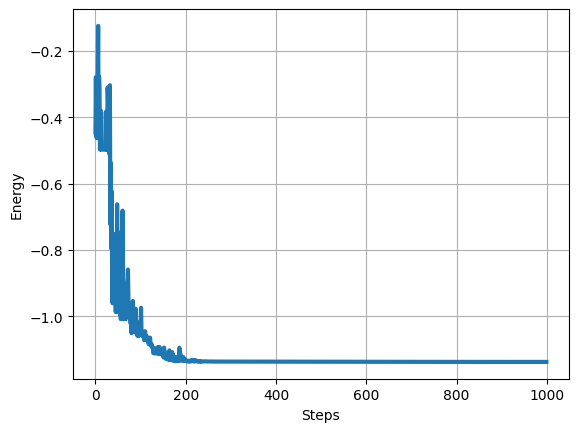

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result.meta_data["optimization_trace"]), lw=3)

plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

In [18]:
eigvals = np.linalg.eigvalsh(H_sp.get_matrix())
E_min = min(eigvals)
print("E_min (exact diagonalization) = %s" % (E_min))

#print("optimization_trace =", eval(result.meta_data["optimization_trace"]))
#print("optimization_trace =", result.meta_data["optimization_trace"])
theta_VQE = result.meta_data["parameters"]
print("Optimal theta (VQE): %s" % theta_VQE)
print("E (VQE) = %s (err = %s %%)" % (result.value, 100 * abs((result.value - E_min) / E_min)))

E_min (exact diagonalization) = -1.137270167926503
Optimal theta (VQE): [0.5608548374628116, 1.5210263755323286, 1.5001944039362243, -0.022978405624502523, 0.02045237005299844, 0.2248498756706707, 0.04739865624975831, 1.9789778839687684, 0.17358711563496132, 2.0455299645652794, 0.45753710505219497, -0.19482551337266363, 0.8677943727056794, 0.5170347436020795, 0.8527391416444959, 0.732105212470321, 1.0203370848881679, 0.5985203449743574, 1.1038655781484508, 0.3962235360017256, 0.40308458901777927, 0.8969023749921368, 0.23359681646237984, 0.48278093271419614, 0.5480774530284986, 0.813211621819622, -0.05547699111754722, 0.20062029863815967, -0.07823869188065548, 0.2672565931893387, 1.9107469758082316, 0.2382474249208003]
E (VQE) = -1.1371302602331657 (err = 0.012302063070233703 %)



### Challenge 1:

Is there a hardware-efficient ansatz better than the one provided. Better = fewer CNOT gates with accuracy and almost equal number of "quantum-classical" iterations

### Challenge 2:

Change the interatomic distance, calculate the minimum energy for each distance, draw the curve Energie_minimale = f(interatomic distance).

The result should look like that:

![image.png](images/potential-energy_VS_internuclear-distance.png)

**The code performs two main tasks related to the H₂ molecule:**

**1. Quantum Chemistry Computation:**  
**The first part of the code utilizes the PySCF library to compute various energy levels for the H2 molecule at different internuclear distances.**  
- It defines the molecular geometry, basis set, spin, and charge, and iterates over a range of distances (from 0.30 to 2.00 Å).  
- For each distance, it performs quantum chemical calculations to obtain the Hartree-Fock (HF), MP2, and Full Configuration Interaction (FCI) energies, along with the reduced density matrix and other molecular properties.  
- The results are saved in `.npz` files for later analysis.

**2. Data Visualization:**  
**The second part of the code reads the saved data files and plots the computed energies against the internuclear distances.**  
- It loads the energy values and distances from the `.npz` files and stores them in lists.  
- If valid data is found, it creates a scatter plot to visualize the relationship between the internuclear distance and the energies (HF, MP2, and FCI), providing insights into the molecular behavior as the distance changes.  
- The plot includes labels, a title, and a legend for clarity.


#### Simulate more geometry with PySCF

In [19]:
""" from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation  # Import the function to perform PySCF computations
import numpy as np  # Import NumPy for numerical operations

# Define basis, spin, and charge for the molecular system
basis = "sto-3g"  # Specify the basis set for the calculation
spin = 0  # Specify the total spin (0 for singlet state)
charge = 0  # Specify the molecular charge (0 for neutral molecule)

# Define the list of internuclear distances (in Angstroms) for the H2 molecule
distances = np.arange(0.30, 2.05, 0.05)  # Create an array of distances from 0.30 to 2.00 Å

# Loop over each internuclear distance
for distance in distances:
    # Set the molecule geometry with the current distance
    geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, distance))]  # Define the position of hydrogen atoms

    # Perform the PySCF computation
    (
        rdm1,  # Reduced density matrix
        orbital_energies,  # Energies of the molecular orbitals
        nuclear_repulsion,  # Energy from nuclear repulsion
        n_electrons,  # Number of electrons in the system
        one_body_integrals,  # One-body integrals
        two_body_integrals,  # Two-body integrals
        info,  # Dictionary containing additional information
    ) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)  # Run the computation with FCI

    # Display computed energies
    print(
        f"Distance: {distance} Å\n",  # Print the current internuclear distance
        f" HF energy :  {info['HF']}\n",  # Print the Hartree-Fock energy
        f"MP2 energy : {info['MP2']}\n",  # Print the MP2 energy
        f"FCI energy : {info['FCI']}\n",  # Print the Full Configuration Interaction energy
    )

    nqbits = rdm1.shape[0] * 2  # Calculate the number of qubits needed for the density matrix
    print("Number of qubits = ", nqbits)  # Print the number of qubits

    # Save results to a .npz file with distance in the filename and include the distance in the file content
    filename = f"data/h2_data_{distance:.2f}.npz"  # Define the filename for saving data
    np.savez(filename,
             distance=distance,   # Save the internuclear distance in the file
             rdm1=rdm1,  # Save the reduced density matrix
             orbital_energies=orbital_energies,  # Save the orbital energies
             nuclear_repulsion=nuclear_repulsion,  # Save nuclear repulsion energy
             n_electrons=n_electrons,  # Save number of electrons
             one_body_integrals=one_body_integrals,  # Save one-body integrals
             two_body_integrals=two_body_integrals,  # Save two-body integrals
             hf_energy=info['HF'],  # Save Hartree-Fock energy
             mp2_energy=info['MP2'],  # Save MP2 energy
             fci_energy=info['FCI'],  # Save Full CI energy
             nqbits=nqbits)  # Save number of qubits """

' from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation  # Import the function to perform PySCF computations\nimport numpy as np  # Import NumPy for numerical operations\n\n# Define basis, spin, and charge for the molecular system\nbasis = "sto-3g"  # Specify the basis set for the calculation\nspin = 0  # Specify the total spin (0 for singlet state)\ncharge = 0  # Specify the molecular charge (0 for neutral molecule)\n\n# Define the list of internuclear distances (in Angstroms) for the H2 molecule\ndistances = np.arange(0.30, 2.05, 0.05)  # Create an array of distances from 0.30 to 2.00 Å\n\n# Loop over each internuclear distance\nfor distance in distances:\n    # Set the molecule geometry with the current distance\n    geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, distance))]  # Define the position of hydrogen atoms\n\n    # Perform the PySCF computation\n    (\n        rdm1,  # Reduced density matrix\n        orbital_energies,  # Energies of the molecular orb

**Then plot the graph**

Distance not found in file 'h2_data.npz'. Skipping this file.
Error processing file 'h2_data.npz': 'hf_energy is not a file in the archive'


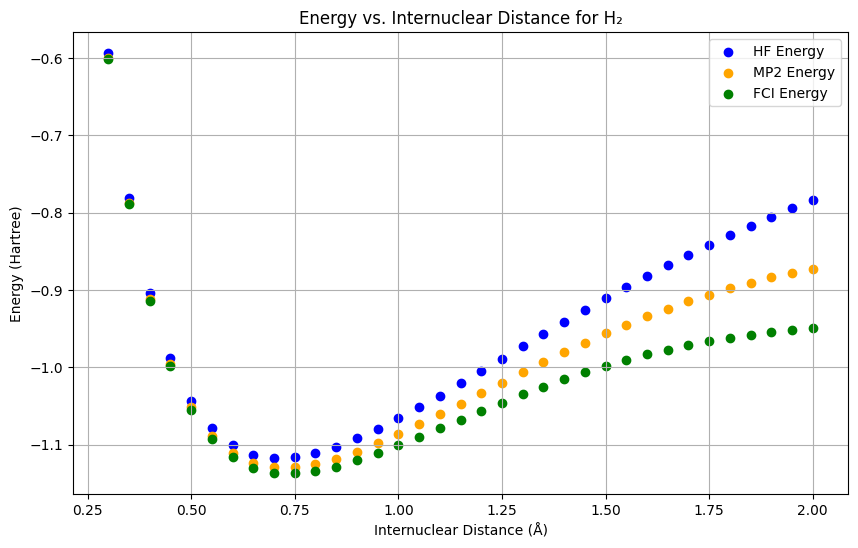

In [20]:
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import os  # Import OS for file operations

# Lists to hold energy values and distances
hf_energies = []  # List to store Hartree-Fock energies
mp2_energies = []  # List to store MP2 energies
fci_energies = []  # List to store Full Configuration Interaction energies
distances = []  # List to store internuclear distances

# Load each .npz file from the 'data' folder
for filename in os.listdir("data"):  # Iterate through files in the 'data' directory
    if filename.endswith(".npz"):  # Check if the file has a .npz extension
        try:
            # Load the data from the file
            data = np.load(os.path.join("data", filename))  # Load the .npz file

            # Extract distance
            try:
                distance = data['distance']  # Get the distance value from the data
                distances.append(distance)  # Append the distance to the list
            except KeyError:
                print(f"Distance not found in file '{filename}'. Skipping this file.")  # Error message if distance is not present

            # Append the energies to the corresponding lists
            hf_energies.append(data['hf_energy'])  # Append Hartree-Fock energy
            mp2_energies.append(data['mp2_energy'])  # Append MP2 energy
            fci_energies.append(data['fci_energy'])  # Append Full CI energy

        except Exception as e:  # Catch any errors that occur during file processing
            print(f"Error processing file '{filename}': {e}")  # Print error message

# Convert lists to numpy arrays for plotting
distances = np.array(distances)  # Convert distance list to a NumPy array
hf_energies = np.array(hf_energies)  # Convert Hartree-Fock energy list to a NumPy array
mp2_energies = np.array(mp2_energies)  # Convert MP2 energy list to a NumPy array
fci_energies = np.array(fci_energies)  # Convert Full CI energy list to a NumPy array

# Check if any distances or energies were collected
if len(distances) == 0:  # If no distances were collected
    print("No valid data found for plotting.")  # Print message indicating no valid data
else:
    # Plotting the energies against distances
    plt.figure(figsize=(10, 6))  # Create a new figure with specified size
    plt.scatter(distances, hf_energies, marker='o', label='HF Energy', color='blue')  # Plot HF energies
    plt.scatter(distances, mp2_energies, marker='o', label='MP2 Energy', color='orange')  # Plot MP2 energies
    plt.scatter(distances, fci_energies, marker='o', label='FCI Energy', color='green')  # Plot FCI energies

    # Adding labels and title
    plt.title('Energy vs. Internuclear Distance for H₂')  # Set the title of the plot
    plt.xlabel('Internuclear Distance (Å)')  # Set the x-axis label
    plt.ylabel('Energy (Hartree)')  # Set the y-axis label
    plt.legend()  # Show legend for different energy labels
    plt.grid()  # Add a grid to the plot

    # Show the plot
    plt.show()  # Display the plot

#### Let's reproduce the plot with myQLM

In [22]:
import numpy as np  # Import the NumPy library for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import os  # Import OS for file operations
from qat.lang.AQASM import Program, RX, RY, RZ, S  # Quantum programming constructs
from qat.qpus import PyLinalg  # Quantum Processing Unit implementation
from qat.core import Observable  # Class for defining observables

# Initialize a dictionary to store expectation values for each distance
expectation_values_dict = {}

# Get the list of .npz files in the 'data' directory
file_list = [f for f in os.listdir("data") if f.endswith(".npz")]  # Filter .npz files
total_files = len(file_list)  # Total number of files

# Loop through each .npz file in the 'data' directory
for i, filename in enumerate(file_list):
    h2_data = np.load(os.path.join("data", filename), allow_pickle=True)  # Load the .npz file

    # Extract various pieces of data from the loaded file
    nuclear_repulsion = h2_data["nuclear_repulsion"]  # Energy due to nuclear repulsion
    one_body_integrals = h2_data["one_body_integrals"]  # One-body integrals for the Hamiltonian
    two_body_integrals = h2_data["two_body_integrals"]  # Two-body integrals for the Hamiltonian

    try:
        distance = h2_data['distance']  # Get the distance value from the data
    except KeyError:
        print(f"Distance not found in file '{filename}'. Skipping this file.")  # Error message if distance is not present
        continue  # Skip to the next iteration if there's an error


    # Define the molecular hamiltonian
    mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)

    # Compute the ElectronicStructureHamiltonian
    Ham = mol_h.get_electronic_hamiltonian()

    # Transform the electronic Hamiltonian into the Jordan-Wigner basis representation
    hamiltonian_sp = my_transform_to_jw_basis(Ham)

    # Create a quantum program and allocate qubits
    qprogram = Program()
    qbits = qprogram.qalloc(2)

    theta_list = [prog.new_var(float, "\\theta_{%s}" % i) for i in range(32)]

    # Outer loop to iterate over a set of layers in the circuit (4 layers in total)
    for l in range(4):
        # Inner loop to apply the RY rotation gates to the first 4 qubits
        for j in range(4):
            # Apply the RY gate with the corresponding angle from theta_list for the ith qubit in layer l
            qprogram.apply(RY(theta_list[j + 4 * l]), reg[j])

        # Apply CNOT gates between adjacent qubits (creating entanglement)
        for j in range(3):
            # Apply CNOT gate between the ith qubit and the (i+1)th qubit
            qprogram.apply(CNOT, reg[j], reg[j + 1])

        # Apply another layer of RY rotation gates after the CNOT gates
        for j in range(4):
            # Apply the RY gate with the corresponding angle from theta_list for the ith qubit in the next layer
            qprogram.apply(RY(theta_list[j + 4 * (l + 1)]), reg[j])

    # Create a stack of plugins for quantum circuit optimization
    #optimizer_scipy = ScipyMinimizePlugin(method="COBYLA", tol=1e-3, options={"maxiter": 1000})
    #stack = optimizer_scipy | PyLinalg()
    stack = ScipyMinimizePlugin(x0=[0.3, 1.3], method="COBYLA", tol=1e-3, options={"maxiter": 1000}) | PyLinalg()

    # Submit the job to the stack
    res = stack.submit(qprogram.to_circ().to_job(observable=hamiltonian_sp))

    # Fill the dictionary with distance as the key and expectation value as the value
    expectation_values_dict[distance.item()] = res.value

    # Print the progress
    print(f"Processed file {i + 1} of {total_files}: '{filename}'")  # Print current file progress

Distance not found in file 'h2_data.npz'. Skipping this file.
Processed file 2 of 36: 'h2_data_0.30.npz'
Processed file 3 of 36: 'h2_data_0.35.npz'
Processed file 4 of 36: 'h2_data_0.40.npz'
Processed file 5 of 36: 'h2_data_0.45.npz'
Processed file 6 of 36: 'h2_data_0.50.npz'
Processed file 7 of 36: 'h2_data_0.55.npz'
Processed file 8 of 36: 'h2_data_0.60.npz'
Processed file 9 of 36: 'h2_data_0.65.npz'
Processed file 10 of 36: 'h2_data_0.70.npz'
Processed file 11 of 36: 'h2_data_0.75.npz'
Processed file 12 of 36: 'h2_data_0.80.npz'
Processed file 13 of 36: 'h2_data_0.85.npz'
Processed file 14 of 36: 'h2_data_0.90.npz'
Processed file 15 of 36: 'h2_data_0.95.npz'
Processed file 16 of 36: 'h2_data_1.00.npz'
Processed file 17 of 36: 'h2_data_1.05.npz'
Processed file 18 of 36: 'h2_data_1.10.npz'
Processed file 19 of 36: 'h2_data_1.15.npz'
Processed file 20 of 36: 'h2_data_1.20.npz'
Processed file 21 of 36: 'h2_data_1.25.npz'
Processed file 22 of 36: 'h2_data_1.30.npz'
Processed file 23 of 3

**And finaly let's plot the combined graph**

Distance not found in file 'h2_data.npz'. Skipping this file.
Error processing file 'h2_data.npz': 'hf_energy is not a file in the archive'


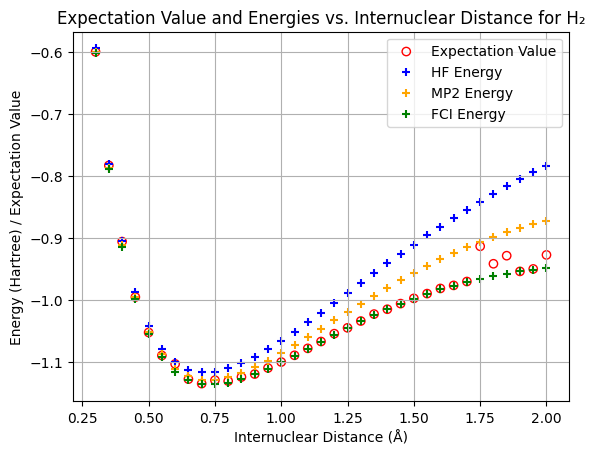

In [23]:
import numpy as np  # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import os  # Import OS for file operations

# Lists to hold energy values and distances
hf_energies = []  # List to store Hartree-Fock energies
mp2_energies = []  # List to store MP2 energies
fci_energies = []  # List to store Full Configuration Interaction energies
distances = []  # List to store internuclear distances

# Load each .npz file from the 'data' folder
for filename in os.listdir("data"):  # Iterate through files in the 'data' directory
    if filename.endswith(".npz"):  # Check if the file has a .npz extension
        try:
            # Load the data from the file
            data = np.load(os.path.join("data", filename))  # Load the .npz file

            # Extract distance
            try:
                distance = data['distance']  # Get the distance value from the data
                distances.append(distance)  # Append the distance to the list
            except KeyError:
                print(f"Distance not found in file '{filename}'. Skipping this file.")  # Error message if distance is not present

            # Append the energies to the corresponding lists
            hf_energies.append(data['hf_energy'])  # Append Hartree-Fock energy
            mp2_energies.append(data['mp2_energy'])  # Append MP2 energy
            fci_energies.append(data['fci_energy'])  # Append Full CI energy

        except Exception as e:  # Catch any errors that occur during file processing
            print(f"Error processing file '{filename}': {e}")  # Print error message

# Convert lists to numpy arrays for plotting
distances = np.array(distances)  # Convert distance list to a NumPy array
hf_energies = np.array(hf_energies)  # Convert Hartree-Fock energy list to a NumPy array
mp2_energies = np.array(mp2_energies)  # Convert MP2 energy list to a NumPy array
fci_energies = np.array(fci_energies)  # Convert Full CI energy list to a NumPy array

expectation_values = list(expectation_values_dict.values())  # Get corresponding expectation values

# Plot the expectation values as a scatter plot
plt.scatter(distances, expectation_values, marker='o', facecolor='none', label='Expectation Value', color='red')  # Plot expectation values

# Plot the energies as continuous curves (line plots)
plt.scatter(distances, hf_energies, label='HF Energy', color='blue', linestyle='-', marker='+')  # HF energies as line plot
plt.scatter(distances, mp2_energies, label='MP2 Energy', color='orange', linestyle='-', marker='+')  # MP2 energies as line plot
plt.scatter(distances, fci_energies, label='FCI Energy', color='green', linestyle='-', marker='+')  # FCI energies as line plot

# Adding labels and title
plt.title('Expectation Value and Energies vs. Internuclear Distance for H₂')  # Set the title of the plot
plt.xlabel('Internuclear Distance (Å)')  # Set the x-axis label
plt.ylabel('Energy (Hartree) / Expectation Value')  # Set the y-axis label
plt.legend()  # Show legend for different data sets
plt.grid()  # Add a grid to the plot

# Show the plot
plt.show()  # Display the plot


### Documentation

* myQLM: https://myqlm.github.io/

* Term in the Pauli basis of an observable: https://myqlm.github.io/04_api_reference/module_qat/module_core/term.html

* Observable: https://myqlm.github.io/04_api_reference/module_qat/module_core/observable.html

* Creating observables: https://myqlm.github.io/02_user_guide/01_write/03_observable.html

* qat.fermion: https://myqlm.github.io/04_api_reference/module_qat/module_fermion.html

* FermionHamiltonian: https://myqlm.github.io/04_api_reference/module_qat/module_fermion/fermionhamiltonian.html

* SpinHamiltonian: https://myqlm.github.io/04_api_reference/module_qat/module_fermion/spinhamiltonian.htm

* Creating and manipulating Hamiltonians: https://myqlm.github.io/fermion/01_hamiltonians.html

* to_job() function: https://myqlm.github.io/04_api_reference/module_qat/module_core/circuit.html#qat.core.Circuit.to_job

### References

* **Kandala, A., Mezzacapo, A., Temme, K., Takita, M., Brink, M., Chow, J. M., & Gambetta, J. M. (2017).** *Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets*. Nature, 549(7671), 242–246. [https://doi.org/10.1038/nature23879](https://doi.org/10.1038/nature23879); [arXiv:1704.05018](https://arxiv.org/abs/1704.05018)

* **Peruzzo, A., McClean, J., Shadbolt, P., Yung, M.-H., Zhou, X.-Q., Love, P. J., Aspuru-Guzik, A., & O’Brien, J. L.** (2014). A variational eigenvalue solver on a photonic quantum processor. *Nature Communications, 5*(1). [https://doi.org/10.1038/ncomms5213](http://dx.doi.org/10.1038/ncomms5213) [arXiv:1304.3061](https://arxiv.org/pdf/1304.3061)